**Atencion multi-cabezal**

obtenido de: https://youtu.be/HQn1QKQYXVg?si=UJMAR_-jHb3K6w09


In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

**Atención de multi-cabezal**

In [3]:
sequence_length = 4
batch_size = 1
input_dim = 512 #dimension del embedding de entrada
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [4]:
x.size()

torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim, 3*d_model)

In [6]:
qkv = qkv_layer(x)

In [7]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

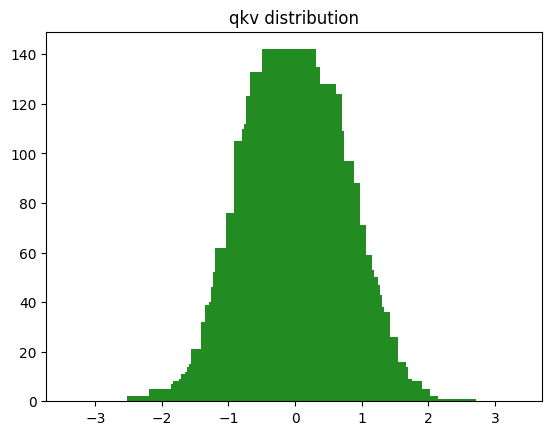

In [9]:
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [11]:
num_heads = 8 #El número de cabezales debe ser multiplo de d_model
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [12]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [13]:
qkv = qkv.permute(0, 2, 1, 3) #[batch_size, num_heads, sequence_length, 3 * head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [14]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

**Self Attention for multiple heads**

In [19]:
d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [20]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [21]:
y = torch.randn(2, 3)
torch.transpose(y, 0, 1)

tensor([[-0.9603,  1.0547],
        [-0.2034, -0.2989],
        [-1.8503,  0.1849]])

In [22]:
torch.transpose(y, 1, 0)

tensor([[-0.9603,  1.0547],
        [-0.2034, -0.2989],
        [-1.8503,  0.1849]])

In [23]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] #mascara para la entrada de un cabezal

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [24]:
(scaled + mask)[0][0]

tensor([[ 0.1427,    -inf,    -inf,    -inf],
        [-0.5581,  0.3368,    -inf,    -inf],
        [ 0.4169, -0.3780, -0.0415,    -inf],
        [-0.1075,  0.0797, -0.3493, -0.4157]], grad_fn=<SelectBackward0>)

In [25]:
scaled += mask

In [26]:
np.exp(0.5596)/(np.exp(0.5596) + np.exp(0.0404))

0.6269606805367254

In [27]:
attention = F.softmax(scaled, dim=-1)

In [28]:
attention.shape

torch.Size([1, 8, 4, 4])

In [29]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.2901, 0.7099, 0.0000, 0.0000],
        [0.4799, 0.2167, 0.3034, 0.0000],
        [0.2684, 0.3237, 0.2107, 0.1972]], grad_fn=<SelectBackward0>)

In [30]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [35]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [36]:
attention.shape

torch.Size([1, 8, 4, 4])

In [37]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.2901, 0.7099, 0.0000, 0.0000],
        [0.4799, 0.2167, 0.3034, 0.0000],
        [0.2684, 0.3237, 0.2107, 0.1972]], grad_fn=<SelectBackward0>)

In [38]:
values.size()

torch.Size([1, 8, 4, 64])

In [39]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [40]:
linear_layer = nn.Linear(d_model, d_model)

In [41]:
out = linear_layer(values)

In [43]:
out.shape

torch.Size([1, 4, 512])

**Obtenemos**

In [46]:
def scaled_dot_product(q, k, v, mask=None):
  d_k = q.size()[-1]
  scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
  if mask is not None:
    scaled += mask
  attention = F.softmax(scaled, dim=-1)
  values = torch.matmul(attention, v)
  return values, attention

class MultiheadAttention(nn.Module):
  def __init__(self, input_dim, d_model, num_heads):
    super().__init__()
    self.input_dim = input_dim
    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads
    self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
    self.linear_layer = nn.Linear(d_model, d_model)

  def forward(self, x, mask=None):
    batch_size, sequence_length, input_dim = x.size()
    print(f"x.size(): {x.size()}")
    qkv = self.qkv_layer(x)
    print(f"qkv.size(): {qkv.size()}")
    qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
    print(f"qkv.size(): {qkv.size()}")
    qkv = qkv.permute(0, 2, 1, 3)
    print(f"qkv.size(): {qkv.size()}")
    q, k, v = qkv.chunk(3, dim=-1)
    print(f"q.size(): {q.size()}, k.size(): {k.size()}, v.size(): {v.size()}")
    values, attention = scaled_dot_product(q, k, v, mask)
    print(f"values.size(): {values.size()}, attention.size(): {attention.size()}")
    values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
    print(f"values.size(): {values.size()}")
    out = self.linear_layer(values)
    print(f"out.size(): {out.size()}")
    return out

**Entradas**

In [47]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q.size(): torch.Size([30, 8, 5, 64]), k.size(): torch.Size([30, 8, 5, 64]), v.size(): torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention.size(): torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
